In [1]:
%matplotlib inline
import scipy.io
import numpy as np
import math
import os
import csv
import umap
import sklearn.datasets
import pandas as pd
import numpy as np
import umap
import re
import umap.plot
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import colorsys
import matplotlib.colors as pltcolors
import plotly.graph_objects as go
from IPython.display import clear_output
from bokeh.models import Button
from bokeh.io import curdoc
from soundsig.sound import WavFile, BioSound
from IPython.display import Audio
from soundsig.signal import bandpass_filter
from soundsig.sound import spectrogram, plot_spectrogram, log_transform, play_sound_array
from ipywidgets import Output

In [22]:
def load_mat(filename):
    """
    This function should be called instead of scipy.io.loadmat
    as it can recover python dictionaries from mat files.
    """

    def _check_keys(d):
        """
        Checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        """
        for key in d:
            if isinstance(d[key], scipy.io.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _todict(matobj):
        """
        A recursive function which constructs from matobjects nested dictionaries
        """
        nested_d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, scipy.io.matlab.mio5_params.mat_struct):
                nested_d[strg] = _todict(elem)
            else:
                nested_d[strg] = elem
        return nested_d

    data = scipy.io.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def open_files(paths):
    mat_objs = []
    for path in paths:
        for file in os.listdir(path):
            if file.endswith("200.mat"):
                mat_objs.append(load_mat(path + "/" + str(file)))
    return mat_objs

def collect_data_mps(mat_objs):
    collected_data = []
    wf, wt = mat_objs[0]['BioSoundCalls'][0][0].wf, mat_objs[0]['BioSoundCalls'][0][0].wt
    w0 = next(x[0] for x in enumerate(wf) if x[1] > 0)
    w1 = next(x[0] for x in enumerate(wf) if x[1] > 0.0025)
    t0 = next(x[0] for x in enumerate(wt) if x[1] > -200)
    t1 = next(x[0] for x in enumerate(wt) if x[1] > 200)
    for mat_obj in mat_objs:
        if 'BioSoundCalls' not in mat_obj.keys():
            continue
        specs = mat_obj['BioSoundCalls']
        if len(specs) > 0 and not isinstance(specs[0], np.ndarray):
            specs = [specs]
        for row in specs:
            try:
                collected_data.append(row[0].mps[w0:w1, t0:t1].flatten())
            except:
                continue
    print("---- Collected MPS sounds ----")
    return l2_norm(np.vstack(collected_data))

def collect(mat_objs): # This function collects mps
    collected_ids = []
    collected_data = []
    wf, wt = mat_objs[0]['BioSoundCalls'][0][0].wf, mat_objs[0]['BioSoundCalls'][0][0].wt
    w0 = next(x[0] for x in enumerate(wf) if x[1] > 0)
    w1 = next(x[0] for x in enumerate(wf) if x[1] > 0.0025)
    t0 = next(x[0] for x in enumerate(wt) if x[1] > -200)
    t1 = next(x[0] for x in enumerate(wt) if x[1] > 200)
    for mat_obj in mat_objs:
        if 'BioSoundFilenames' not in mat_obj.keys() or 'BioSoundCalls' not in mat_obj.keys():
            continue
        
        filenames = mat_obj['BioSoundFilenames']
        if len(filenames) > 0 and filenames.ndim == 1:
            filenames = [filenames]
        
        specs = mat_obj['BioSoundCalls']
        if len(specs) > 0 and not isinstance(specs[0], np.ndarray):
            specs = [specs]
        
        for row_id, row in zip(filenames, specs):
            name = row_id[0]
            try:
                collected_data.append(row[0].mps[w0:w1, t0:t1].flatten())
                x = re.search("Bat\d*", name)
            except (TypeError, AttributeError):
                continue
            name = name[x.start() + 3:x.end()]
            if type(name) == str:
                collected_ids.append(name)
    
    print("---- Collected Mat_objects ----")
    y_set = set(collected_ids)
    hashed_y = {}
    for i, val in enumerate(y_set):
        hashed_y[val] = i
    hashed = lambda x: int(hashed_y[x])
    return np.array(list(y_set)), np.array(collected_ids), l2_norm(np.vstack(collected_data)) # corresponds respectively to y, y_ids and voc_data when called below?

In [23]:
def l2_norm(mats):
    return mats / np.linalg.norm(mats, axis=0)

def avged_norm(mats):
    return (mats - np.min(mats, axis=0)) / (np.max(mats, axis=0) - np.min(mats, axis=0))

In [7]:
#root = os.getcwd()
root = "/Volumes/server_home/users/JulieE/JuvenileRecordings151"
paths = [root + "/20190822/audiologgers", root + "/20190823/audiologgers"]
print(paths)
mat_objs = open_files(paths)

['/Volumes/server_home/users/JulieE/JuvenileRecordings151/20190822/audiologgers', '/Volumes/server_home/users/JulieE/JuvenileRecordings151/20190823/audiologgers']


/var/folders/87/vb4sm2kn10vfzxnyrz__96780000gq/T/ipykernel_14418/435399349.py:13: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  if isinstance(d[key], scipy.io.matlab.mio5_params.mat_struct):


In [8]:
y_ids, y, voc_data = collect(mat_objs) # shouldn't that be y, y_ids, voc_data = collect(mat_objs)?
y_set = set(y)
hashed_y = {}
for i, val in enumerate(y_set):
    hashed_y[val] = i
y = np.vectorize(hashed_y.get)(y)# these last lines look really similar to the first output of collect(), but I'm not sure I understand what it does (converts the bat IDs to numbers 0-4?)

---- Collected Mat_objects ----


In [9]:
voc_data_mps = collect_data_mps(mat_objs) # Here we collect the mps again but this time stored in voc_data_mps instead of voc_data

# getting the mapping between the ids collected and coded in y as integers between 0-4 by collect() and the actual IDs of Bats (so doing the reverse of what the previous cell did?)
hover_data = pd.DataFrame({'index':np.arange(414),
                           'label':y}) 
hover_data['batID'] = hover_data.label.map(
    {0: '14644', 1: '71284', 2: '14647', 3: '65704', 4: '65706'}
)

iph = hover_data.to_dict()
dict_idx = list(iph['index'].values())
iph['index'] = dict_idx
dict_lbl = list(iph['label'].values())
iph['label'] = dict_lbl
dict_batID = list(iph['batID'].values())
iph['batID'] = dict_batID
iph_pd = pd.DataFrame.from_dict(iph)

---- Collected MPS sounds ----


In [34]:
def spec_colormap():
# Makes the colormap that we like for spectrograms

    cmap = np.zeros((64,3))
    cmap[0,2] = 1.0

    for ib in range(21):
        cmap[ib+1,0] = (31.0+ib*(12.0/20.0))/60.0
        cmap[ib+1,1] = (ib+1.0)/21.0
        cmap[ib+1,2] = 1.0

    for ig in range(21):
        cmap[ig+ib+1,0] = (21.0-(ig)*(12.0/20.0))/60.0
        cmap[ig+ib+1,1] = 1.0
        cmap[ig+ib+1,2] = 0.5+(ig)*(0.3/20.0)

    for ir in range(21):
        cmap[ir+ig+ib+1,0] = (8.0-(ir)*(7.0/20.0))/60.0
        cmap[ir+ig+ib+1,1] = 0.5 + (ir)*(0.5/20.0)
        cmap[ir+ig+ib+1,2] = 1

    for ic in range(64):
        (cmap[ic,0], cmap[ic,1], cmap[ic,2]) = colorsys.hsv_to_rgb(cmap[ic,0], cmap[ic,1], cmap[ic,2])
    
    spec_cmap = pltcolors.ListedColormap(cmap, name=u'SpectroColorMap', N=64)
    plt.register_cmap(cmap=spec_cmap, override_builtin=1)

def plot_spectro(t, freq, spec, ax=None, ticks=True, fmin=None, fmax=None, colormap=None, colorbar=True, log = True, dBNoise = 50):
            if colormap == None:
                spec_colormap()
                colormap = plt.get_cmap('SpectroColorMap')

            if ax is None:
                ax = plt.gca()

            if fmin is None:
                fmin = freq.min()
            if fmax is None:
                fmax = freq.max()

            ex = (t.min(), t.max(), freq.min(), freq.max())
            plotSpect = np.abs(spec)


            if log == True and dBNoise is not None:
                plotSpect = 20*np.log10(plotSpect)
                maxB = plotSpect.max()
                minB = maxB-dBNoise
            else:
                if dBNoise is not None:
                    maxB = 20*np.log10(plotSpect.max())
                    minB = ((maxB-dBNoise)/20.0)**10
                else:
                    maxB = plotSpect.max()
                    minB = plotSpect.min()

            plotSpect[plotSpect < minB] = minB

            return ax, ex, colormap, minB, maxB, plotSpect, fmin, fmax, ticks, colorbar
        
def plot_spectrom(ind, ax=None):
    spectro = bioSound_objs_list[ind].spectro/20
    spectro = 10**(spectro)
    return plot_spectro(bioSound_objs_list[ind].to, bioSound_objs_list[ind].fo, spectro, ax=ax, dBNoise=60)

def interactive_plot(u=None, n_neighbors=10, min_dist=0.1, n_components=2, metric='euclidean', title='', ax=None):
#    you can input your own projection values in u
    if u == None:
        fit = umap.UMAP(
            n_neighbors=n_neighbors,
            min_dist=min_dist,
            n_components=n_components,
            metric=metric
        )
        u = fit.fit_transform(voc_data);

    f = go.FigureWidget([go.Scatter(
        x=u[:,0], 
        y=u[:,1], 
        mode='markers',
        customdata=iph_pd[['index', 'label', 'batID']],
        hovertemplate = "<br>".join(["index: %{customdata[0]}", 
                                     "label: %{customdata[1]}",
                                     "batID: %{customdata[2]}<extra></extra>"])
    )])
    scatter = f.data[0]
    scatter.marker.color = y
#     print(len(y), y)
    f.layout.hovermode = 'closest'
#     Audio(bioSound_objs_list[0].sound, rate=bioSound_objs_list[0].samprate, autoplay=True)
    plt.ion()
    ax = None
    iax = None
    out = Output()
    display(out)
    
    def update_point(trace, points, selector):
        nonlocal ax
        nonlocal iax
        nonlocal out
#         c = list(scatter.marker.color)
#         s = list(scatter.marker.size)
#         print(c, s, len(c))
        for i in points.point_inds:
            if iax != None:
                with out:
                    clear_output(wait=True)
            if ax == None:
                ax, ex, colormap, minB, maxB, plotSpect, fmin, fmax, ticks, colorbar = plot_spectrom(i, ax)
                with out:
                    iax = ax.imshow(plotSpect, aspect='auto', interpolation='nearest', origin='lower', extent=ex, cmap=colormap, vmin=minB, vmax=maxB)
                    ax.set_ylim(fmin, fmax)
                    if not ticks:
                        ax.set_xticks([])
                        ax.set_yticks([])
                    else:
                        ax.set_ylabel('Frequency (Hz)')
                        ax.set_xlabel('Time (s)')

                    if colorbar:
                        plt.colorbar(iax)
                    play_audio(i)
            else:
                ax, ex, colormap, minB, maxB, plotSpect, fmin, fmax, ticks, colorbar = plot_spectrom(i, ax)
                with out:
                    iax = ax.imshow(plotSpect, aspect='auto', interpolation='nearest', origin='lower', extent=ex, cmap=colormap, vmin=minB, vmax=maxB)
                    plt.sca(ax)
                    plt.show()
                    play_audio(i)
#             c[i] = '#bae2be' 
#             s[i] = 20
#             with f.batch_update():
#                 scatter.marker.color = c
#                 scatter.marker.size = s
    scatter.on_click(update_point)
    
    return f

def collect_bioSound_objs(root=None, files=None, mat_objs=None, y=y): # collects all biosound objects (including spectro)
    if files: # make it compatible with Deaf bats dataset
        if root == None:
            root = os.getcwd()
        files = files if isinstance(files, list) else [files]
        paths = [root + file for file in files]
        print(paths)
        mat_objs = open_files(paths)
        y_ids, y, voc_data = collect(mat_objs)
        y_set = set(y)
        hashed_y = {}
        for i, val in enumerate(y_set):
            hashed_y[val] = i
        y = np.vectorize(hashed_y.get)(y)
    collected_data = []
    for mat_obj in mat_objs:
        if 'BioSoundCalls' not in mat_obj.keys():
            continue
        specs = mat_obj['BioSoundCalls']
        if len(specs) > 0 and not isinstance(specs[0], np.ndarray):
            specs = [specs]
        for row in specs:
            if row[0] != [] and 'mps' in row[0]._fieldnames:
                collected_data.append(row[0])
    print("---- Collected Biosound Objects ----")
    return collected_data, y

def play_audio(index):
#      sound > 100 --> pad zeros (np.pad)
    sound = bioSound_objs_list[index].sound - np.mean(bioSound_objs_list[index].sound)
    sound = sound / np.std(bioSound_objs_list[index].sound)
    display(Audio(sound, rate=bioSound_objs_list[index].samprate, autoplay=True))

In [11]:
bioSound_objs_list, y = collect_bioSound_objs(mat_objs=mat_objs, y=y)

---- Collected Biosound Objects ----


/var/folders/87/vb4sm2kn10vfzxnyrz__96780000gq/T/ipykernel_14418/4291528804.py:157: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if row[0] != [] and 'mps' in row[0]._fieldnames:


Output()

FigureWidget({
    'data': [{'customdata': array([[0, 0, '14644'],
                                   [1, 4, '…

/var/folders/87/vb4sm2kn10vfzxnyrz__96780000gq/T/ipykernel_14418/361017594.py:26: MatplotlibDeprecationWarning:

The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.

/var/folders/87/vb4sm2kn10vfzxnyrz__96780000gq/T/ipykernel_14418/361017594.py:26: UserWarning:

Overwriting the cmap 'SpectroColorMap' that was already in the registry.



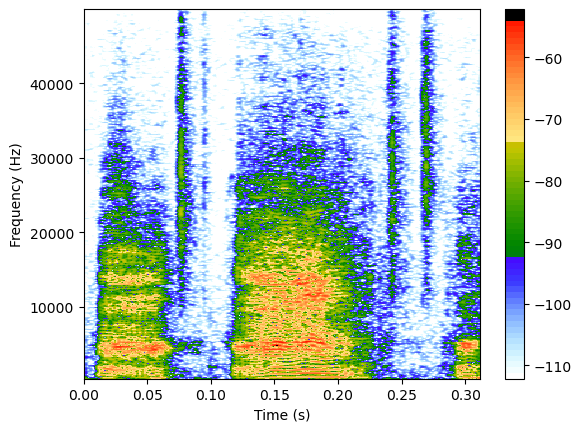

/var/folders/87/vb4sm2kn10vfzxnyrz__96780000gq/T/ipykernel_14418/361017594.py:26: MatplotlibDeprecationWarning:

The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.

/var/folders/87/vb4sm2kn10vfzxnyrz__96780000gq/T/ipykernel_14418/361017594.py:26: UserWarning:

Overwriting the cmap 'SpectroColorMap' that was already in the registry.



In [19]:
f = interactive_plot()
f


In [35]:
# Collect all data that have been processed for the deaf bats
path = "/Volumes/server_home/users/JulieE/DeafSalineGroup151"
files = ["/20200123/audiologgers", "/20200124/audiologgers", "/20200127/audiologgers", 
         "/20200128/audiologgers", "/20200129/audiologgers", "/20200130/audiologgers", 
         "/20200131/audiologgers", "/20200207/audiologgers", "/20200213/audiologgers",
        "/20200221/audiologgers", "/20200227/audiologgers", "/20200306/audiologgers",
        "/20200312/audiologgers"]
bioSound_objs_list, y = collect_bioSound_objs(root = path, files=files, mat_objs=None)
len(y)
len(bioSound_objs_list)

['/Volumes/server_home/users/JulieE/DeafSalineGroup151/20200123/audiologgers', '/Volumes/server_home/users/JulieE/DeafSalineGroup151/20200124/audiologgers', '/Volumes/server_home/users/JulieE/DeafSalineGroup151/20200127/audiologgers', '/Volumes/server_home/users/JulieE/DeafSalineGroup151/20200128/audiologgers', '/Volumes/server_home/users/JulieE/DeafSalineGroup151/20200129/audiologgers', '/Volumes/server_home/users/JulieE/DeafSalineGroup151/20200130/audiologgers', '/Volumes/server_home/users/JulieE/DeafSalineGroup151/20200131/audiologgers', '/Volumes/server_home/users/JulieE/DeafSalineGroup151/20200207/audiologgers', '/Volumes/server_home/users/JulieE/DeafSalineGroup151/20200213/audiologgers', '/Volumes/server_home/users/JulieE/DeafSalineGroup151/20200221/audiologgers', '/Volumes/server_home/users/JulieE/DeafSalineGroup151/20200227/audiologgers', '/Volumes/server_home/users/JulieE/DeafSalineGroup151/20200306/audiologgers', '/Volumes/server_home/users/JulieE/DeafSalineGroup151/20200312/

/var/folders/87/vb4sm2kn10vfzxnyrz__96780000gq/T/ipykernel_14418/3897128257.py:13: DeprecationWarning:

Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.



KeyboardInterrupt: 

In [ ]:
# Load the projection values calculated before in Matlab

# Call the interactive plot on these data and projections
interactive_plot(u=UMAPProjections)